# Option Pricing Methods Comparison

This notebook compares three pricing methods:
1. Black-Scholes Analytical (closed-form)
2. PDE Finite Difference (explicit, implicit, Crank-Nicolson)
3. Monte Carlo (standard, antithetic, control variates)

**Objectives:**
- Verify numerical methods against analytical solution
- Compare accuracy, speed, and stability
- Analyze convergence properties

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pricers.black_scholes import BlackScholesPricer
from pricers.pde_pricer import PDEPricer
from pricers.monte_carlo import MonteCarloPricer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Base Case Comparison

In [2]:
# Parameters
S = 100.0    # Spot price
K = 100.0    # Strike (ATM)
T = 1.0      # 1 year
r = 0.05     # 5% risk-free rate
sigma = 0.2  # 20% volatility
q = 0.0      # No dividends

option_type = 'call'

print("=" * 60)
print("OPTION PRICING COMPARISON")
print("=" * 60)
print(f"Spot: ${S:.2f} | Strike: ${K:.2f} | Time: {T:.2f}y")
print(f"Rate: {r:.2%} | Vol: {sigma:.2%} | Type: {option_type.upper()}")
print("=" * 60)

OPTION PRICING COMPARISON
Spot: $100.00 | Strike: $100.00 | Time: 1.00y
Rate: 5.00% | Vol: 20.00% | Type: CALL


### Black-Scholes (Benchmark)

In [3]:
bs = BlackScholesPricer(S, K, T, r, sigma, q)

start = time.time()
bs_price = bs.price(option_type)
bs_time = time.time() - start

print(f"Black-Scholes Price: ${bs_price:.6f}")
print(f"Computation Time: {bs_time*1000:.4f} ms")

# Greeks
greeks = bs.all_greeks(option_type)
print("\nGreeks:")
for greek, value in greeks.items():
    print(f"  {greek.capitalize():8s}: {value:10.6f}")

Black-Scholes Price: $10.450584
Computation Time: 0.5200 ms

Greeks:
  Price   :  10.450584
  Delta   :   0.636831
  Gamma   :   0.018762
  Vega    :   0.375240
  Theta   :  -0.017573
  Rho     :   0.532325


### PDE Methods

In [4]:
# PDE parameters
M = 100   # Space steps
N = 1000  # Time steps

pde = PDEPricer(S, K, T, r, sigma, q, M=M, N=N)

methods = ['explicit', 'implicit', 'crank-nicolson']
pde_results = {}

for method in methods:
    start = time.time()
    price = pde.price(option_type, method=method)
    elapsed = time.time() - start
    
    error = abs(price - bs_price)
    rel_error = error / bs_price * 100
    
    pde_results[method] = {
        'price': price,
        'time': elapsed,
        'error': error,
        'rel_error': rel_error
    }
    
    print(f"\n{method.upper()}:")
    print(f"  Price: ${price:.6f}")
    print(f"  Error: ${error:.6f} ({rel_error:.4f}%)")
    print(f"  Time:  {elapsed*1000:.2f} ms")


EXPLICIT:
  Price: $0.000000
  Error: $10.450584 (100.0000%)
  Time:  7.65 ms

IMPLICIT:
  Price: $-0.000000
  Error: $10.450584 (100.0000%)
  Time:  53.93 ms

CRANK-NICOLSON:
  Price: $10.465710
  Error: $0.015126 (0.1447%)
  Time:  33.95 ms


### Monte Carlo Methods

In [5]:
n_sims = 100000
mc = MonteCarloPricer(S, K, T, r, sigma, q, n_simulations=n_sims, seed=42)

mc_methods = ['standard', 'antithetic', 'control_variate']
mc_results = {}

for method in mc_methods:
    start = time.time()
    result = mc.price(option_type, method=method)
    elapsed = time.time() - start
    
    price = result['price']
    std_err = result['std_error']
    error = abs(price - bs_price)
    rel_error = error / bs_price * 100
    
    mc_results[method] = {
        'price': price,
        'std_error': std_err,
        'time': elapsed,
        'error': error,
        'rel_error': rel_error,
        'ci_width': result['ci_width']
    }
    
    print(f"\n{method.upper()}:")
    print(f"  Price:    ${price:.6f} ± ${std_err:.6f}")
    print(f"  Error:    ${error:.6f} ({rel_error:.4f}%)")
    print(f"  CI Width: ${result['ci_width']:.6f}")
    print(f"  Time:     {elapsed*1000:.2f} ms")
    
    if 'variance_reduction_ratio' in result:
        print(f"  Var Reduction: {result['variance_reduction_ratio']:.2%}")


STANDARD:
  Price:    $10.473892 ± $0.046589
  Error:    $0.023308 (0.2230%)
  CI Width: $0.182630
  Time:     6.78 ms

ANTITHETIC:
  Price:    $10.448406 ± $0.046500
  Error:    $0.002178 (0.0208%)
  CI Width: $0.182281
  Time:     3.45 ms

CONTROL_VARIATE:
  Price:    $10.445839 ± $0.017722
  Error:    $0.004744 (0.0454%)
  CI Width: $0.069472
  Time:     6.50 ms
  Var Reduction: 14.64%


## 2. Summary Comparison Table

In [6]:
# Create summary DataFrame
summary_data = []

# Black-Scholes
summary_data.append({
    'Method': 'Black-Scholes',
    'Price': bs_price,
    'Time (ms)': bs_time * 1000,
    'Error': 0.0,
    'Rel Error (%)': 0.0
})

# PDE methods
for method, res in pde_results.items():
    summary_data.append({
        'Method': f'PDE ({method})',
        'Price': res['price'],
        'Time (ms)': res['time'] * 1000,
        'Error': res['error'],
        'Rel Error (%)': res['rel_error']
    })

# MC methods
for method, res in mc_results.items():
    summary_data.append({
        'Method': f'MC ({method})',
        'Price': res['price'],
        'Time (ms)': res['time'] * 1000,
        'Error': res['error'],
        'Rel Error (%)': res['rel_error']
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


SUMMARY TABLE
              Method         Price  Time (ms)     Error  Rel Error (%)
       Black-Scholes  1.045058e+01   0.519991  0.000000       0.000000
      PDE (explicit)  1.256520e-14   7.651806 10.450584     100.000000
      PDE (implicit) -1.304237e-15  53.925991 10.450584     100.000000
PDE (crank-nicolson)  1.046571e+01  33.951998  0.015126       0.144739
       MC (standard)  1.047389e+01   6.778717  0.023308       0.223034
     MC (antithetic)  1.044841e+01   3.454924  0.002178       0.020841
MC (control_variate)  1.044584e+01   6.497860  0.004744       0.045396


## 3. Convergence Analysis

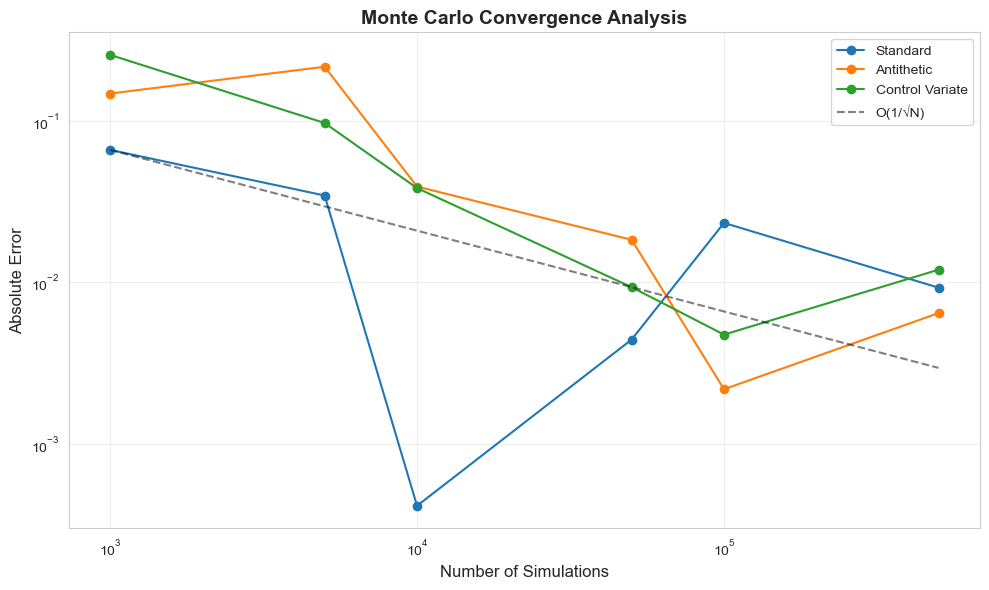

In [7]:
# Monte Carlo convergence
sim_sizes = [1000, 5000, 10000, 50000, 100000, 500000]
mc_convergence = {method: [] for method in mc_methods}

for n_sim in sim_sizes:
    mc_temp = MonteCarloPricer(S, K, T, r, sigma, q, n_simulations=n_sim, seed=42)
    
    for method in mc_methods:
        result = mc_temp.price(option_type, method=method)
        error = abs(result['price'] - bs_price)
        mc_convergence[method].append(error)

# Plot convergence
fig, ax = plt.subplots(figsize=(10, 6))

for method in mc_methods:
    ax.loglog(sim_sizes, mc_convergence[method], 'o-', label=method.replace('_', ' ').title())

# Theoretical O(1/√N) line
theoretical = [mc_convergence['standard'][0] * np.sqrt(sim_sizes[0] / n) for n in sim_sizes]
ax.loglog(sim_sizes, theoretical, 'k--', label='O(1/√N)', alpha=0.5)

ax.set_xlabel('Number of Simulations', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Monte Carlo Convergence Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Moneyness Analysis

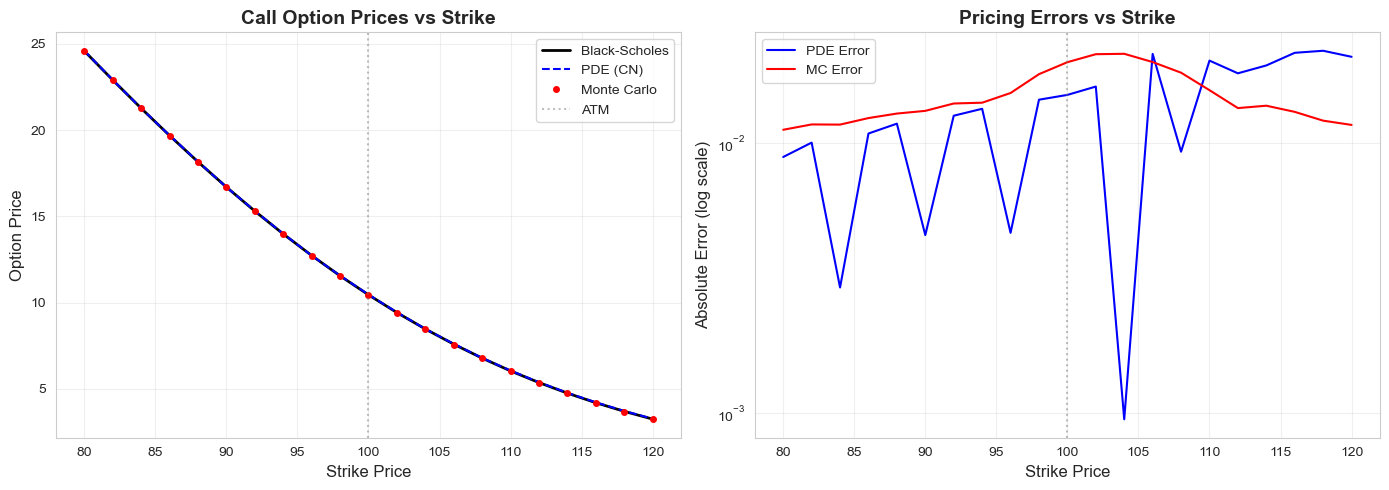

In [8]:
# Test across different strike prices
strikes = np.linspace(80, 120, 21)
moneyness_results = {'strike': strikes, 'BS': [], 'PDE': [], 'MC': []}

for K_test in strikes:
    # Black-Scholes
    bs_test = BlackScholesPricer(S, K_test, T, r, sigma, q)
    bs_price_test = bs_test.price(option_type)
    moneyness_results['BS'].append(bs_price_test)
    
    # PDE (Crank-Nicolson)
    pde_test = PDEPricer(S, K_test, T, r, sigma, q, M=100, N=1000)
    pde_price_test = pde_test.price(option_type, method='crank-nicolson')
    moneyness_results['PDE'].append(pde_price_test)
    
    # Monte Carlo (antithetic)
    mc_test = MonteCarloPricer(S, K_test, T, r, sigma, q, n_simulations=50000, seed=42)
    mc_price_test = mc_test.price(option_type, method='antithetic')['price']
    moneyness_results['MC'].append(mc_price_test)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prices
ax1.plot(strikes, moneyness_results['BS'], 'k-', linewidth=2, label='Black-Scholes')
ax1.plot(strikes, moneyness_results['PDE'], 'b--', label='PDE (CN)')
ax1.plot(strikes, moneyness_results['MC'], 'ro', markersize=4, label='Monte Carlo')
ax1.axvline(S, color='gray', linestyle=':', alpha=0.5, label='ATM')
ax1.set_xlabel('Strike Price', fontsize=12)
ax1.set_ylabel('Option Price', fontsize=12)
ax1.set_title('Call Option Prices vs Strike', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Errors
pde_errors = np.abs(np.array(moneyness_results['PDE']) - np.array(moneyness_results['BS']))
mc_errors = np.abs(np.array(moneyness_results['MC']) - np.array(moneyness_results['BS']))

ax2.semilogy(strikes, pde_errors, 'b-', label='PDE Error')
ax2.semilogy(strikes, mc_errors, 'r-', label='MC Error')
ax2.axvline(S, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Strike Price', fontsize=12)
ax2.set_ylabel('Absolute Error (log scale)', fontsize=12)
ax2.set_title('Pricing Errors vs Strike', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Key Findings

**Summary:**
- Black-Scholes: Exact, fastest (microseconds)
- PDE: Accurate, moderate speed (milliseconds), CN most stable
- Monte Carlo: Flexible, slowest, variance reduction helps

**Use Cases:**
- European vanilla options → Black-Scholes
- American/barrier options → PDE
- Path-dependent exotics → Monte Carlo